<a href="https://colab.research.google.com/github/koshygeoji/Covid-Detection-using-Lung-Xray-Images/blob/master/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the dataset from drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip /content/drive/My\ Drive/cdac/data/data.zip 

Streaming output truncated to the last 5000 lines.
 extracting: content/data/normal/NORMAL2-IM-0287-0001.jpeg  
 extracting: content/data/normal/IM-0225-0001.jpeg  
 extracting: content/data/normal/IM-0547-0001.jpeg  
 extracting: content/data/normal/NORMAL2-IM-0529-0001.jpeg  
 extracting: content/data/normal/NORMAL2-IM-0540-0001.jpeg  
 extracting: content/data/normal/IM-0536-0001.jpeg  
 extracting: content/data/normal/IM-0564-0001.jpeg  
 extracting: content/data/normal/NORMAL2-IM-0278-0001.jpeg  
 extracting: content/data/normal/IM-0640-0001-0002.jpeg  
 extracting: content/data/normal/NORMAL2-IM-1024-0001.jpeg  
 extracting: content/data/normal/NORMAL2-IM-0995-0001-0002.jpeg  
 extracting: content/data/normal/IM-0033-0001-0001.jpeg  
 extracting: content/data/normal/IM-0001-0001.jpeg  
 extracting: content/data/normal/IM-0010-0001.jpeg  
 extracting: content/data/normal/NORMAL2-IM-0305-0001.jpeg  
 extracting: content/data/normal/NORMAL2-IM-1008-0001.jpeg  
 extracting: content/d

Finding tensorflow strategy

In [0]:
import re
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
# from kaggle_datasets import KaggleDatasets
# Detect hardware, return appropriate distribution strategy

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.2.0-rc3
REPLICAS:  1


Setting learn rate schedule

Learning rate schedule: 1e-05 to 5e-05 to 2.64e-05


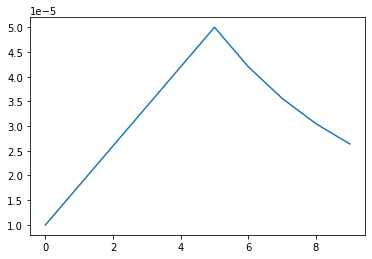

In [0]:
if tpu:
  BATCH_SIZE = 16*strategy.num_replicas_in_sync  # A TPU has 8 cores so this will be 128
else:
  BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)


BATCH_SIZE = 16 * strategy.num_replicas_in_sync # this is 8 on TPU v3-8, it is 1 on CPU and GPU
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(10)] #In range of Epoches
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

**Aug Model creation**-our own model

In [0]:
from __future__ import division

import os

import tensorflow as tf
from tensorflow.keras import Input, Model, layers
from tensorflow.keras import backend as K
from keras.engine import get_source_inputs
from tensorflow.keras.layers import Activation, SeparableConv2D, BatchNormalization, Dropout
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Add, Concatenate, SeparableConv2D
from tensorflow.keras.layers import Convolution2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import ZeroPadding2D, GlobalMaxPooling2D, Cropping2D, Lambda
def create_model():
    import h5py
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Activation, concatenate, Add, Conv2DTranspose
    from tensorflow.keras.layers import Flatten, Dropout, Dense, GlobalMaxPooling2D
    from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, DepthwiseConv2D, Conv2D, Bidirectional, LSTM
    from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, Maximum
    from tensorflow.keras.constraints import MinMaxNorm
    from tensorflow.keras.regularizers import l2
    # import tensorflow_transform as tft
    import numpy as np
    import tensorflow.keras.backend as K
    # import keras.backend as K
    # K.clear_session()

    def correct_pad(backend, inputs, kernel_size):
        """Returns a tuple for zero-padding for 2D convolution with downsampling.
        # Arguments
            input_size: An integer or tuple/list of 2 integers.
            kernel_size: An integer or tuple/list of 2 integers.
        # Returns
            A tuple.
        """
        img_dim = 2 if backend.image_data_format() == 'channels_first' else 1
        input_size = backend.int_shape(inputs)[img_dim:(img_dim + 2)]

        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)

        if input_size[0] is None:
            adjust = (1, 1)
        else:
            adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)

        correct = (kernel_size[0] // 2, kernel_size[1] // 2)

        return ((correct[0] - adjust[0], correct[0]),
                (correct[1] - adjust[1], correct[1]))

    def _make_divisible(v, divisor, min_value=None):
        if min_value is None:
            min_value = divisor
        new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
        # Make sure that round down does not go down by more than 10%.
        if new_v < 0.9 * v:
            new_v += divisor
        return new_v

    def PEPX(inputs, stride, filters, alpha, block_id):
      """
        • First-stage Projection: 1×1 convolutions for projecting input features to a lower dimension,
        • Expansion: 1×1 convolutions for expanding features
            to a higher dimension that is different than that of the
            input features,
        • Depth-wise Representation: efficient 3×3 depthwise convolutions for learning spatial characteristics to
            minimize computational complexity while preserving
            representational capacity,
        • Second-stage Projection: 1×1 convolutions for projecting features back to a lower dimension, and
        • Extension: 1×1 convolutions that finally extend channel dimensionality to a higher dimension to produce
             the final features.
             
      """
      channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
      in_channels = K.int_shape(inputs)[channel_axis]
      pointwise_conv_filters = int(filters * alpha)
      pointwise_filters = _make_divisible(pointwise_conv_filters, 3)
      x = inputs
      prefix = 'block_PEPX_{}_'.format(block_id)
      x = layers.Conv2D(pointwise_conv_filters,
          kernel_size=1,
          padding='same',
          use_bias=False,
          activation=None,
          name=prefix + '01')(x)
      x = layers.Conv2D(pointwise_conv_filters, 
                                 kernel_size=1, 
                                 padding='same', 
                                 use_bias=False, 
                                 activation=None, 
                                 name=prefix + '02')(x)
      x = layers.DepthwiseConv2D(3,
              strides=stride,
              activation=None,
              use_bias=False,
              padding='same' if stride == 1 else 'valid',
              name=prefix + 'depthwise_03')(x)
      x = layers.Conv2D(pointwise_conv_filters,
          kernel_size=1,
          padding='same',
          use_bias=False,
          activation=None,
          name=prefix + '04')(x)
      x = layers.Conv2D(pointwise_conv_filters,
          kernel_size=1,
          padding='same',
          use_bias=False,
          activation=None,
          name=prefix + '05')(x)          
      if in_channels == pointwise_filters and stride == 1:
          return layers.Add(name=prefix + 'add_PEPX_' )([inputs, x])
      return x
    def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
        channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

        in_channels = K.int_shape(inputs)[channel_axis]
        pointwise_conv_filters = int(filters * alpha)
        pointwise_filters = _make_divisible(pointwise_conv_filters, 9)
        x = inputs
        prefix = 'block_{}_'.format(block_id)

        if block_id:
            # Expand
            x = layers.SeparableConv2D(expansion * in_channels,
                              kernel_size=1,
                              padding='same',
                              use_bias=False,
                              activation=None,
                              name=prefix + 'expand')(x)
            # x = layers.BatchNormalization(axis=channel_axis,
            #                               epsilon=1e-3,
            #                               momentum=0.999,
            #                               name=prefix + 'expand_BN')(x)
            x = layers.ELU(6., name=prefix + 'expand_elu' )(x)
        else:
            prefix = 'expanded_conv_'

        # Depthwise
        if stride == 2:
            x = layers.ZeroPadding2D(padding=correct_pad(K, x, 3),
                                     name=prefix + 'pad')(x)
        x = layers.DepthwiseConv2D(kernel_size=3,
                                   strides=stride,
                                   activation=None,
                                   use_bias=False,
                                   padding='same' if stride == 1 else 'valid',
                                   name=prefix + 'depthwise')(x)
        # x = layers.BatchNormalization(axis=channel_axis,
        #                               epsilon=1e-3,
        #                               momentum=0.999,
        #                               name=prefix + 'depthwise_BN')(x)

        x = layers.ELU(6., name=prefix + 'depthwise_elu' )(x)

        # Project
        x = layers.SeparableConv2D(pointwise_filters,
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          activation=None,
                          name=prefix + 'project' )(x)
        # x = layers.BatchNormalization(axis=channel_axis,
        #                               epsilon=1e-3,
        #                               momentum=0.999,
        #                               name=prefix + 'project_BN' )(x)

        if in_channels == pointwise_filters and stride == 1:
            return layers.Add(name=prefix + 'add' )([inputs, x])
        return x
    def gelu(x):
        return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

    def swish(x):
        """Swish activation function.
        # Arguments
            x: Input tensor.
        # Returns
            The Swish activation: `x * sigmoid(x)`.
        # References
            [Searching for Activation Functions](https://arxiv.org/abs/1710.05941)
        """
        if tf.keras.backend.backend() == 'tensorflow':
            try:
                # The native TF implementation has a more
                # memory-efficient gradient implementation
                return tf.keras.backend.tf.nn.swish(x)
            except AttributeError:
                pass

        return x * tf.keras.backend.sigmoid(x)
    def SubpixelConv2D(input_shape, scale=2):
        """
            Keras layer to do subpixel convolution.
            NOTE: Tensorflow backend only. Uses tf.depth_to_space

            Ref:
                [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
                    Shi et Al.
                    https://arxiv.org/abs/1609.05158

            :param input_shape: tensor shape, (batch, height, width, channel)
            :param scale: upsampling scale. Default=4
            :return:
            """
            # upsample using depth_to_space
        def subpixel_shape(input_shape):
            dims = [input_shape[0],
                    input_shape[1] * scale,
                    input_shape[2] * scale,
                    int(input_shape[3] / (scale ** 2))]
            output_shape = tuple(dims)
            return output_shape

        def subpixel(x):
            return tf.compat.v1.depth_to_space(x, scale)


        return Lambda(subpixel, output_shape=subpixel_shape, name='subpixel') 
    f ='relu'
    f2 = swish
    n_classes = 3
    inputs = (224, 224, 1)
    alpha = 1.0 
    input_img = Input(shape=inputs)


    conv1 = Conv2D(3, (7, 7), activation=f, padding='same', name='conv1')(input_img)
    sep_conv1 = SeparableConv2D(3, (7, 7), activation=f, padding='same', name='sep_conv1')(conv1)

    
    
    fire2_squeeze = PEPX(sep_conv1, filters=4, stride=1, alpha=alpha, block_id=0)
    fire2_expand1 =  _inverted_res_block(fire2_squeeze, filters=3, alpha=alpha, stride=1, expansion=1, block_id=0)
    fire2_expand2 = _inverted_res_block(fire2_squeeze, filters=3, alpha=alpha, stride=1, expansion=1, block_id=1)
    
    concatenate2 = concatenate([fire2_expand2, fire2_expand1, conv1], axis=-1)
    
    maxpool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='maxpool2')(concatenate2)
    
    conv2 = Conv2D(3, (7, 7), activation=f, padding='same', name='conv2')(maxpool2)
    sep_conv2 = SeparableConv2D(3, (7, 7), activation=f, padding='same', name='sep_conv2')(conv2)
    
    fire3_squeeze = PEPX(sep_conv2, filters=8, stride=1, alpha=alpha, block_id=1)
    fire3_expand1 = _inverted_res_block(fire3_squeeze, filters=3, alpha=alpha, stride=1, expansion=1, block_id=2)
    fire3_expand2 = _inverted_res_block(fire3_squeeze, filters=3, alpha=alpha, stride=1, expansion=1, block_id=3)
    concatenate3 = concatenate([fire3_expand1, fire3_expand2, conv2], axis=-1)
    
    maxpool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='maxpool3')(concatenate3)

    conv3 = Conv2D(3, (7, 7), activation=f, padding='same', name='conv3')(maxpool3)
    sep_conv3 = SeparableConv2D(3, (7, 7), activation=f, padding='same', name='sep_conv3')(conv3)
    
    fire4_squeeze = PEPX(sep_conv3, filters=16, stride=1, alpha=alpha, block_id=2)
    fire4_expand1 = _inverted_res_block(fire4_squeeze, filters=3, alpha=alpha, stride=1, expansion=1, block_id=4)
    fire4_expand2 = _inverted_res_block(fire4_squeeze, filters=3, alpha=alpha, stride=1, expansion=1, block_id=5)
    concatenate4 = concatenate([fire4_expand1, fire4_expand2, conv3], axis=-1)
    
    maxpool4 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool4')(concatenate4)

    conv4 = Conv2D(3, (7, 7), activation=f, padding='same', name='conv4')(maxpool4)
    sep_conv4 = SeparableConv2D(3, (7, 7), activation=f, padding='same', name='sep_conv4')(conv4)
    
    fire5_squeeze = PEPX(sep_conv4, filters=32, stride=1, alpha=alpha, block_id=3)
    fire5_expand1 = _inverted_res_block(fire5_squeeze, filters=3, alpha=alpha, stride=1, expansion=1, block_id=6)
    fire5_expand2 = _inverted_res_block(fire5_squeeze, filters=3, alpha=alpha, stride=1, expansion=1, block_id=7)
    
    concatenate5 = concatenate([fire5_expand1, fire5_expand2, conv4], axis=-1)
    maxpool5 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool5')(concatenate5)

    conv5 = Conv2D(3, (7, 7), activation=f, padding='same', name='conv5')(maxpool5)
    sep_conv5 = SeparableConv2D(3, (7, 7), activation=f, padding='same', name='sep_conv5')(conv5)
    
    fire6_squeeze = PEPX(sep_conv5, filters=64, stride=1, alpha=alpha, block_id=4)
    fire6_expand1 = _inverted_res_block(fire6_squeeze, filters=3, alpha=alpha, stride=1, expansion=1, block_id=8)
    fire6_expand2 = _inverted_res_block(fire6_squeeze, filters=3, alpha=alpha, stride=1, expansion=1, block_id=9)
    
    concatenate6 = concatenate([fire6_expand1, fire6_expand2, conv5], axis=-1)
    maxpool6 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool6')(concatenate6)  

    avgpool10 = GlobalAveragePooling2D( name='AvgPooll10')(maxpool6)
    

    dense = Dense(100, activation=f)(avgpool10)
    dense = Dense(100, activation=f)(dense)
    drop = Dropout(0.5, name='drop')(dense)
    out = Dense(n_classes)(drop)

    softmax = Activation("softmax", name='softmax')(out)
    model = Model(inputs=input_img, outputs=softmax)
    model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

with strategy.scope():
    model = create_model()
model.summary()


Using TensorFlow backend.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 224, 224, 3)  150         input_1[0][0]                    
__________________________________________________________________________________________________
sep_conv1 (SeparableConv2D)     (None, 224, 224, 3)  159         conv1[0][0]                      
__________________________________________________________________________________________________
block_PEPX_0_01 (Conv2D)        (None, 224, 224, 4)  12          sep_conv1[0][0]                  
______________________________________________________________________________________________

Plotting the model

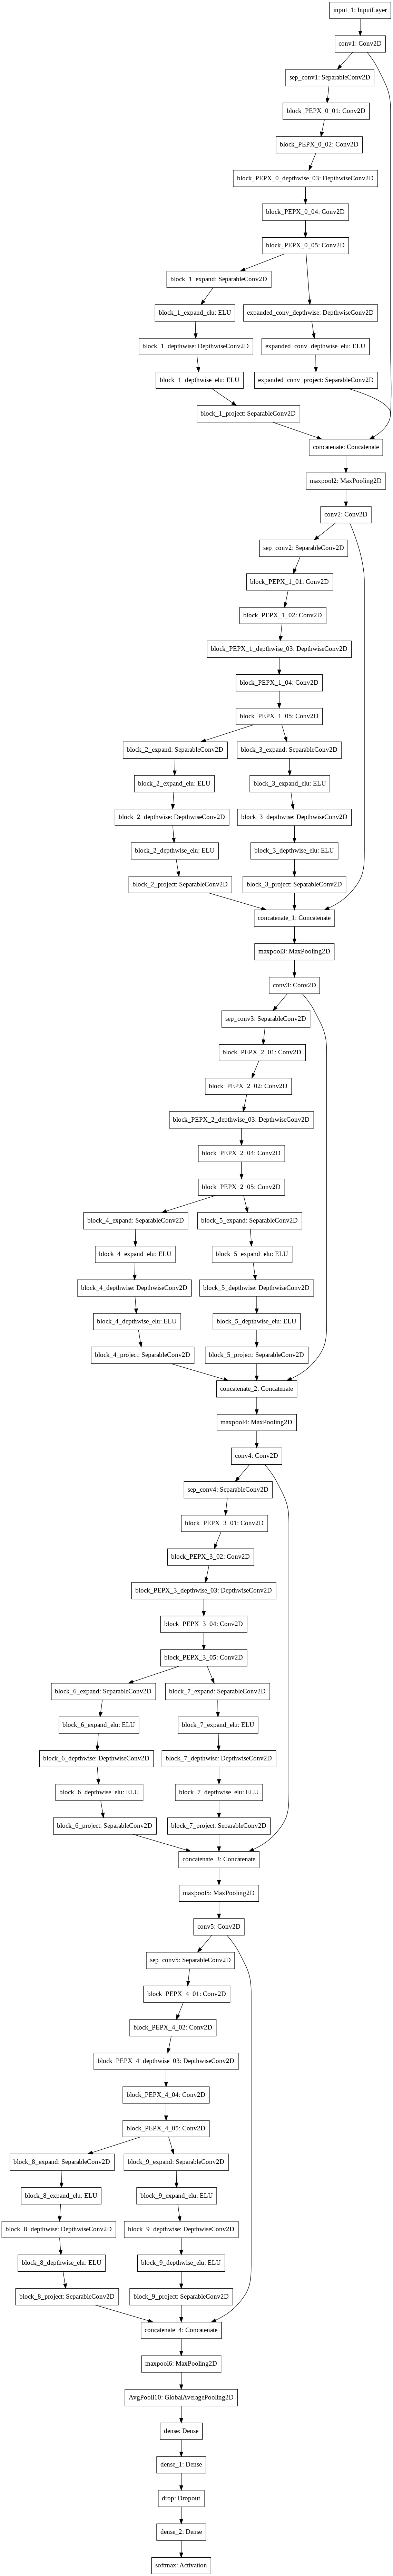

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

Image Data Generator- splitting into test and train

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_dir='/content/content/data'
batch_size=32
train_datagen = ImageDataGenerator(
      validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


Found 4947 images belonging to 3 classes.
Found 1235 images belonging to 3 classes.


Training the model

Model have been trained for 100 epochs.(5 times running the fit option)

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/cdac/Saved/Checkpoint/modelfinal0_100.{epoch:02d}.hdf5', verbose=1, save_best_only=True,
                               monitor = 'val_loss')
csv_logger = CSVLogger('/content/drive/My Drive/cdac/Saved/Log/model0.log')

history=model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 20,
    callbacks=[csv_logger, checkpointer])

model.save('/content/drive/My Drive/cdac/model/model_final_100v2.hdf5', overwrite=True, include_optimizer=True)

Epoch 1/20
154/154 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.6848
Epoch 00001: val_loss improved from inf to 0.64582, saving model to /content/drive/My Drive/cdac/Saved/Checkpoint/modelfinal0_100.01.hdf5
154/154 [==============================] - 50s 324ms/step - loss: 0.7759 - accuracy: 0.6848 - val_loss: 0.6458 - val_accuracy: 0.7023
Epoch 2/20
154/154 [==============================] - ETA: 0s - loss: 0.5620 - accuracy: 0.7778
Epoch 00002: val_loss improved from 0.64582 to 0.51978, saving model to /content/drive/My Drive/cdac/Saved/Checkpoint/modelfinal0_100.02.hdf5
154/154 [==============================] - 50s 325ms/step - loss: 0.5620 - accuracy: 0.7778 - val_loss: 0.5198 - val_accuracy: 0.7903
Epoch 3/20
154/154 [==============================] - ETA: 0s - loss: 0.3936 - accuracy: 0.8541
Epoch 00003: val_loss improved from 0.51978 to 0.45491, saving model to /content/drive/My Drive/cdac/Saved/Checkpoint/modelfinal0_100.03.hdf5
154/154 [=============

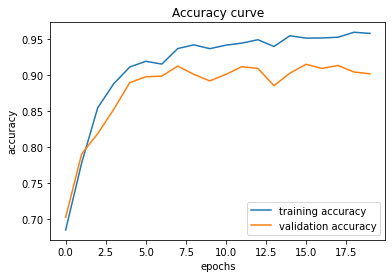

In [0]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Accuracy curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

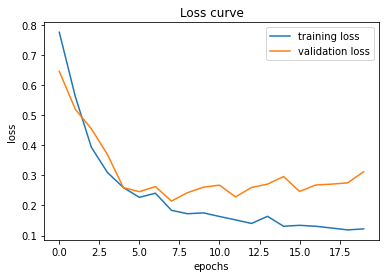

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

**Generating confusion matrix and classification report for the whole data**

Loading the saved model with 100 epochs

In [0]:
from tensorflow.keras import models
model = models.load_model('/content/drive/My Drive/cdac/model/model_final_100.hdf5')

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 224, 224, 3)  150         input_1[0][0]                    
__________________________________________________________________________________________________
sep_conv1 (SeparableConv2D)     (None, 224, 224, 3)  159         conv1[0][0]                      
__________________________________________________________________________________________________
block_PEPX_0_01 (Conv2D)        (None, 224, 224, 4)  12          sep_conv1[0][0]                  
______________________________________________________________________________________________

Predicting the output and taking the ground truth

In [0]:
pred_value=[]
gnd_truth=[]
import os
from tensorflow.keras.preprocessing import image
import numpy as np
for dirname, _, filenames in os.walk('/content/content/data'):
  for filename in filenames:
    imgpath=dirname+'/'+filename
    print(imgpath)
    img = image.load_img(imgpath, target_size=(224, 224),color_mode = "grayscale")
    img = image.img_to_array(img)
                  
    img = np.expand_dims(img, axis=0)         
    #img /= 255.                                      #

    pred = model.predict(img)
    index = np.argmax(pred)
    class_list=['covid','normal','pneumonia']
    class_list.sort()


    pred_value.append(class_list[index])

    gnd_truth.append(dirname.split('/')[4])
    #print(pred_value)


Streaming output truncated to the last 5000 lines.
/content/content/data/pneumonia/person9_bacteria_39.jpeg
/content/content/data/pneumonia/person1312_bacteria_3318.jpeg
/content/content/data/pneumonia/person85_bacteria_424.jpeg
/content/content/data/pneumonia/person296_bacteria_1397.jpeg
/content/content/data/pneumonia/person747_virus_1370.jpeg
/content/content/data/pneumonia/person113_bacteria_541.jpeg
/content/content/data/pneumonia/person1502_bacteria_3923.jpeg
/content/content/data/pneumonia/person23_bacteria_87.jpeg
/content/content/data/pneumonia/person96_bacteria_465.jpeg
/content/content/data/pneumonia/person473_bacteria_2018.jpeg
/content/content/data/pneumonia/person862_virus_1507.jpeg
/content/content/data/pneumonia/person337_bacteria_1562.jpeg
/content/content/data/pneumonia/person710_virus_1308.jpeg
/content/content/data/pneumonia/person401_virus_798.jpeg
/content/content/data/pneumonia/person470_bacteria_1996.jpeg
/content/content/data/pneumonia/person36_virus_81.jpeg
/c

Confusion matrix

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print('confusion_matrix, label- covid, normal, pneumonia')
print(confusion_matrix(gnd_truth, pred_value,labels=['covid','normal','pneumonia']))


confusion_matrix, label- covid, normal, pneumonia
[[ 267    3   14]
 [   6 1528   42]
 [  26   49 4247]]


Classification report

In [0]:
print('classification_report')
print(classification_report(gnd_truth, pred_value, target_names=['covid','normal','pneumonia']))

classification_report
              precision    recall  f1-score   support

       covid       0.89      0.94      0.92       284
      normal       0.97      0.97      0.97      1576
   pneumonia       0.99      0.98      0.98      4322

    accuracy                           0.98      6182
   macro avg       0.95      0.96      0.96      6182
weighted avg       0.98      0.98      0.98      6182



# Conclusion

We have created a dataset with covid xray images from multiple databases with three main class- normal, pnemonia and covid. We used our own custom model 'AugModel' for the classification of the dataset

We have obtained accuracy of about 98% while testing the whole dataset. Number of parameters in model are 59K.

The covid data is limited in numbers compared to normal and pneumonia. So with increase of images with covid, accuracy can be better improved.




***Thanks and regards***

# *--Team AUGGEN21*